In [2]:
import re
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

/Users/helmibousetta/Documents/ds_challenge_alpas/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the dataset
df = pd.read_csv("../data/inputs/ds_challenge_alpas.csv").drop(columns=["Unnamed: 0"])

# Display the first few rows of the dataset
df.head()

,entity_1,entity_2,tag
0,preciform A.B,Preciform AB,1
1,degener staplertechnik vertriebs-gmbh,Irshim,0
2,Alltel South CaroliNA Inc,alltel south carolina INC.,1
3,cse Corporation,Cse Corp,1
4,Gruppo D Motors Srl,gruppo d motors Sociedad de Resposabilidad Lim...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7042846 entries, 0 to 7042845
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   entity_1  object
 1   entity_2  object
 2   tag       int64 
dtypes: int64(1), object(2)
memory usage: 161.2+ MB


In [6]:
df

,entity_1,entity_2,tag
0,preciform A.B,Preciform AB,1
1,degener staplertechnik vertriebs-gmbh,Irshim,0
2,Alltel South CaroliNA Inc,alltel south carolina INC.,1
3,cse Corporation,Cse Corp,1
4,Gruppo D Motors Srl,gruppo d motors Sociedad de Resposabilidad Lim...,1
...,...,...,...
7042841,danbury fair hyundai,alfredo's foreign cars,0
7042842,T B I T Tecnologia & Sistemas SA,t b i t tecnologia +,1
7042843,stereographics Corp),Stereographics Corp,1
7042844,Shanghai Mingdou Chemical CoLTD,shanghai mingdou chemical,1


## Data Preprocessing

In [7]:
# --- Data Preprocessing ---

# Define the preprocessing function
def preprocess_entity_name(entity_name):
    # Lowercasing
    entity_name = entity_name.lower()
    # Remove punctuation and special characters
    entity_name = re.sub(r'[^\w\s]', '', entity_name)

    return entity_name

In [8]:
# Apply preprocessing to each entity name column
df['processed_entity_1'] = df['entity_1'].apply(preprocess_entity_name)
df['processed_entity_2'] = df['entity_2'].apply(preprocess_entity_name)

# Save the preprocessed dataset
df.to_csv("../data/inputs/preprocessed_data.csv", index=False)

## Exploratory Data Analysis (EDA)

In [24]:
df['tag'].value_counts()

tag
0    4162006
1    2880840
Name: count, dtype: int64

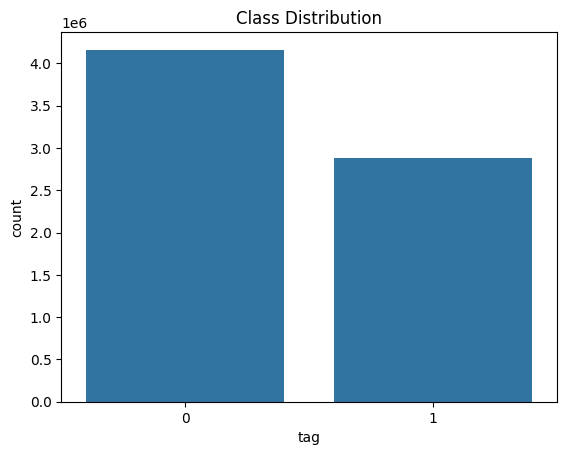

In [8]:
# Class Distribution
sns.countplot(x='tag', data=df)
plt.title('Class Distribution')
plt.show()

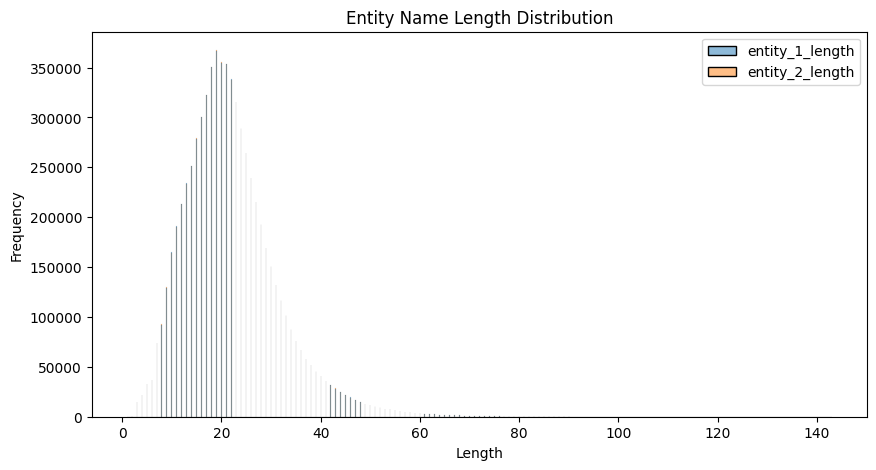

In [9]:
# Entity Name Length
df['entity_1_length'] = df['processed_entity_1'].apply(len)
df['entity_2_length'] = df['processed_entity_2'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df[['entity_1_length', 'entity_2_length']])
plt.title('Entity Name Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

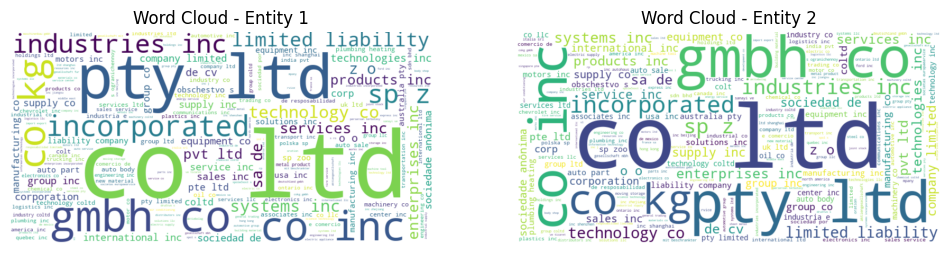

In [15]:
# Common Words and Phrases
wordcloud_entity_1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['processed_entity_1']))
wordcloud_entity_2 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['processed_entity_2']))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_entity_1, interpolation='bilinear')
plt.title('Word Cloud - Entity 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_entity_2, interpolation='bilinear')
plt.title('Word Cloud - Entity 2')
plt.axis('off')

plt.show()



In [16]:
# Tagged Examples
positive_matches = df[df['tag'] == 1].head()
negative_matches = df[df['tag'] == 0].head()

print("Positive Matches:")
print(positive_matches)

print("\nNegative Matches:")
print(negative_matches)

Positive Matches:
                                     entity_1  \
0                               preciform A.B   
2                   Alltel South CaroliNA Inc   
3                             cse Corporation   
4                         Gruppo D Motors Srl   
6  omne Aktiengesellschaftate systems pvt ltd   

                                            entity_2  tag  \
0                                       Preciform AB    1   
2                         alltel south carolina INC.    1   
3                                           Cse Corp    1   
4  gruppo d motors Sociedad de Resposabilidad Lim...    1   
6                         Omne Agate Systems Pvt Ltd    1   

                           processed_entity_1  \
0                                preciform ab   
2                   alltel south carolina inc   
3                             cse corporation   
4                         gruppo d motors srl   
6  omne aktiengesellschaftate systems pvt ltd   

                         

## Model training

In [9]:
# Define a function to average word vectors for a given text
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    n_words = 0
    for word in words:
        if word in vocabulary:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

# Function to compute the average word vectors for a dataset
def get_avg_feature_vectors(data, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    avg_feature_vectors = [average_word_vectors(tokens, model, vocabulary, num_features) for tokens in data]
    return np.array(avg_feature_vectors)

In [10]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
# Define the features (X) and target variable (y)
X_train = train_data[['entity_1', 'entity_2']]
y_train = train_data['tag']
X_test = test_data[['entity_1', 'entity_2']]
y_test = test_data['tag']

In [12]:
# Tokenize the text data
tokenized_train_data = [sentence.split() for sentence in X_train['entity_1'] + ' ' + X_train['entity_2']]
tokenized_test_data = [sentence.split() for sentence in X_test['entity_1'] + ' ' + X_test['entity_2']]

In [13]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train_data, vector_size=100, window=5, min_count=1, workers=4)

In [27]:
# Save the trained Word2Vec model
word2vec_model.save("../models/word2vec_model.model")

- vector_size (100): This parameter defines the size of the feature vectors. Larger vectors may capture more complex relationships in the data, but they also require more computational resources. A common choice is between 100 to 300 dimensions.

- window (5): The window parameter defines the maximum distance between the current and predicted word within a sentence. It determines the context window for word relationships. A smaller window size focuses on more local context, while a larger window captures broader semantic relationships.

- min_count (1): This parameter ignores all words with a total frequency lower than the specified count. Setting it to 1 allows the model to learn embeddings for even infrequently occurring words. However, in some cases, setting a higher min_count can help filter out noise.

- workers (4): This parameter sets the number of CPU cores to be used for training the model. Parallelizing the training process can significantly speed up the training time.

In [14]:
# Get average word vectors for training and testing data
X_train_w2v = get_avg_feature_vectors(tokenized_train_data, word2vec_model, 100)
X_test_w2v = get_avg_feature_vectors(tokenized_test_data, word2vec_model, 100)

In [15]:
X_train_w2v.shape, X_test_w2v.shape

((5634276, 100), (1408570, 100))

In [16]:
# Split the training data into smaller batches
batch_size = 100000  # You can adjust this based on your available memory
num_batches = len(X_train_w2v) // batch_size + 1

In [19]:
models = {
    # 'LogisticRegression': LogisticRegression(random_state=42),
    # 'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

In [21]:
# Train and evaluate each model
# Create a dictionnary to store training results
results_dict = dict()

# Loop over models
for model_name, model in models.items():
    print(f'Training {model_name}...')
    
    # Initialize the model
    clf = model
    
    # Train the model in batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X_train))
        
        # Get average word vectors for the current batch
        X_train_batch_w2v = get_avg_feature_vectors(tokenized_train_data[start_idx:end_idx], word2vec_model, 100)
        
        # Fit the model on the current batch
        clf.fit(X_train_batch_w2v, y_train[start_idx:end_idx])
    
    # Save the trained model
    model_filename = f'{model_name}_model.joblib'
    model_file_path = '../models/' + model_filename
    joblib.dump(clf, model_filename)
    print(f'{model_name} model saved as {model_filename}')
    
    # Evaluate the model on the test set
    X_test_w2v = get_avg_feature_vectors(tokenized_test_data, word2vec_model, 100)
    y_pred = clf.predict(X_test_w2v)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Print and store the results in the dictionary
    print(f'\n{model_name} Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:\n', report)
    
    # Store results in the dictionary
    results_dict[model_name] = {
        'accuracy': accuracy,
        'classification_report': report
    }


Training Random Forest...

Random Forest Results:
Accuracy: 0.9511
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96    832259
           1       0.92      0.96      0.94    576311

    accuracy                           0.95   1408570
   macro avg       0.95      0.95      0.95   1408570
weighted avg       0.95      0.95      0.95   1408570

Training Gradient Boosting...

Gradient Boosting Results:
Accuracy: 0.9356
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95    832259
           1       0.91      0.93      0.92    576311

    accuracy                           0.94   1408570
   macro avg       0.93      0.94      0.93   1408570
weighted avg       0.94      0.94      0.94   1408570

Training XGBoost...

XGBoost Results:
Accuracy: 0.9582
Classification Report:
               precision    recall  f1-score   support

           0       0.9

In [22]:
results_dict

{'Random Forest': {'accuracy': 0.9510986319458742,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.97      0.94      0.96    832259\n           1       0.92      0.96      0.94    576311\n\n    accuracy                           0.95   1408570\n   macro avg       0.95      0.95      0.95   1408570\nweighted avg       0.95      0.95      0.95   1408570\n'},
 'Gradient Boosting': {'accuracy': 0.9356020645051364,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.95      0.94      0.95    832259\n           1       0.91      0.93      0.92    576311\n\n    accuracy                           0.94   1408570\n   macro avg       0.93      0.94      0.93   1408570\nweighted avg       0.94      0.94      0.94   1408570\n'},
 'XGBoost': {'accuracy': 0.958168213152346,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.97      0.96

Considering the class distribution and the importance of correctly identifying similar entities (Class 1), we often want to minimize false negatives (instances where the model predicts dissimilarity when they are similar). This makes recall a valuable metric.

Therefore, I would be considering the model that maximizes both accuracy and recall, with an emphasis on minimizing false negatives. This ensures that the model is effective in identifying instances of similarity (Class 1) while maintaining overall accuracy.


Here's a summary of the results:

- Random Forest
    - Accuracy: 95.11%
    - Precision (Class 1): 92%
    - Recall (Class 1): 96%
    - F1-Score (Class 1): 94%
- Gradient Boosting
    - Accuracy: 93.56%
    - Precision (Class 1): 91%
    - Recall (Class 1): 93%
    - F1-Score (Class 1): 92%
- XGBoost
    - Accuracy: 95.82%
    - Precision (Class 1): 94%
    - Recall (Class 1): 96%
    - F1-Score (Class 1): 95%

Given the output, we can consider that XGBoost was had the best performances for our task (focusing on maximising the Accuracy and Recall)

In [ ]:
# Hyperparameter tuning for the best model (XGBClassifier in this case)

# Define the XGBoost model
xgb_model = XGBClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7, 9],        # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage to prevent overfitting
    'subsample': [0.8, 0.9, 1.0],     # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees
    'gamma': [0, 1, 5],                # Minimum loss reduction required to make a further partition on a leaf node
}


In [ ]:
# Perform random search with cross-validation
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=3, verbose=2, n_jobs=-1
)

In [ ]:
# Use a subset of the training data for faster hyperparameter tuning
subset_size = 100000  # can be adjusted this based on available resources
X_train_subset = X_train.iloc[:subset_size, :]
y_train_subset = y_train.iloc[:subset_size]

In [ ]:
# Fit the random search on the subset of the training data
random_search.fit(X_train_subset, y_train_subset)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

We can then launch the training process again with the updated hyperparameters

## Model Evaluation

In [26]:
# Evaluate the best model on the test set
# best_model = random_search.best_estimator_ 
best_model = clf
y_pred = best_model.predict(X_test_w2v)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print and store the results in the dictionary
print(f'Best Model Results:')
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', report)

# Store results in the dictionary
results_dict['best_model'] = {
    'accuracy': accuracy,
    'classification_report': report
}

Best Model Results:
Accuracy: 0.9582
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96    832259
           1       0.94      0.96      0.95    576311

    accuracy                           0.96   1408570
   macro avg       0.96      0.96      0.96   1408570
weighted avg       0.96      0.96      0.96   1408570



## Prediction

In [28]:
# Load the trained Word2Vec model
word2vec_model = Word2Vec.load("../models/word2vec_model.model")

# Load the trained XGBoost model
xgb_model = joblib.load("../models/XGBoost_model.joblib")

# Function to get average word vectors for new input
def get_avg_feature_vectors_new_input(input_data, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    avg_feature_vectors = [average_word_vectors(tokens, model, vocabulary, num_features) for tokens in input_data]
    return np.array(avg_feature_vectors)

# Function to predict using the trained XGBoost model
def predict_similarity(entity_1, entity_2, word2vec_model, xgb_model):
    # Tokenize the input data
    input_data = [sentence.split() for sentence in [entity_1 + ' ' + entity_2]]
    
    # Get average word vectors for the new input
    input_w2v = get_avg_feature_vectors_new_input(input_data, word2vec_model, 100)
    
    # Make predictions using the trained XGBoost model
    predictions = xgb_model.predict(input_w2v)
    
    return predictions

In [38]:
# Example usage:
entity_1_example = "entity_1"
entity_2_example = "entity_2"

predictions = predict_similarity(entity_1_example, entity_2_example, word2vec_model, xgb_model)
print("Predictions:", predictions)

Predictions: [1]


## Fine-tune a snetence transformer

For fine-tuning we don't need the whole dataset, we can just use a sample of 10K rows (that can be changed)

In [39]:
# Assuming 'tag' is your target column indicating the class
# Identify the minority and majority classes
minority_class = df['tag'].value_counts().idxmin()
majority_class = df['tag'].value_counts().idxmax()

# Sample an equal number of rows for each class
df_minority = df[df['tag'] == minority_class].sample(n=5000, random_state=42)
df_majority = df[df['tag'] == majority_class].sample(n=5000, random_state=42)

# Combine the sampled subsets
df_balanced = pd.concat([df_minority, df_majority])

# Split the balanced dataset into training and testing sets
train_data, test_data = train_test_split(df_balanced, test_size=0.2, random_state=42)


In [43]:
train_data.shape, test_data.shape

((8000, 5), (2000, 5))

In [44]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['entity_1']) + ' [SEP] ' + str(self.data.iloc[index]['entity_2'])
        inputs = self.tokenizer(text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(self.data.iloc[index]['tag'], dtype=torch.long)
        }



In [45]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define dataset and dataloaders
train_dataset = CustomDataset(train_data, tokenizer)
test_dataset = CustomDataset(test_data, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()



tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 11.2kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 937kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.27MB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 2.65MB/s]
model.safetensors: 100%|██████████| 440M/440M [03:25<00:00, 2.15MB/s] 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/helmibousetta/Documents/ds_challenge_alpas/venv/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [46]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Average Loss: {average_loss}")

Epoch 1: 100%|██████████| 1000/1000 [15:09<00:00,  1.10it/s]


Epoch 1, Average Loss: 0.05828892752551474


Epoch 2: 100%|██████████| 1000/1000 [14:55<00:00,  1.12it/s]


Epoch 2, Average Loss: 0.01796256639751664


Epoch 3: 100%|██████████| 1000/1000 [14:43<00:00,  1.13it/s]

Epoch 3, Average Loss: 0.018144032779629924


In [47]:
# Save the fine-tuned model
model.save_pretrained("../models/fine_tuned_BERT_model")

In [48]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Generate the classification report
report_dict = classification_report(true_labels, predictions, target_names=['Class 0', 'Class 1'], output_dict=True)

# Save metrics in a dictionary
evaluation_metrics = {
    'accuracy': accuracy_score(true_labels, predictions),
    'classification_report': report_dict
}

# Print and use the metrics as needed
print("Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value}")

Evaluating: 100%|██████████| 250/250 [01:01<00:00,  4.05it/s]

Evaluation Metrics:
accuracy: 0.9955
classification_report: {'Class 0': {'precision': 0.9989806320081549, 'recall': 0.9919028340080972, 'f1-score': 0.9954291518537329, 'support': 988.0}, 'Class 1': {'precision': 0.9921491658488715, 'recall': 0.9990118577075099, 'f1-score': 0.9955686853766618, 'support': 1012.0}, 'accuracy': 0.9955, 'macro avg': {'precision': 0.9955648989285132, 'recall': 0.9954573458578035, 'f1-score': 0.9954989186151973, 'support': 2000.0}, 'weighted avg': {'precision': 0.9955239101315575, 'recall': 0.9955, 'f1-score': 0.995499755816335, 'support': 2000.0}}


Note: 

These results can be improved by:

- Inncreasing the size of the training data (currently 10K)
- hyperparameters tuning
- Benchmarking multiple sentence transformers and keeping the bes one